<div class="alert alert-info " role="alert">
  <h1 class="alert-heading"><strong>Demonstration Exercise 1/1</strong></h1>
  <hr>
  <p>David Apagyi, 2025-03-21</p>
</div>

In [1]:
from dataclasses import dataclass
from heapq import heapify, heappop, heappush

import matplotlib.pyplot as plt
import simpy
from matplotlib.patches import Rectangle

In [2]:
@dataclass
class Customer:
    arrival_time: int
    service_length: int
    id: int | None = None
    server: int | None = None
    departure_time: int | None = None


class ServerSystem:
    def __init__(self, num_servers: int = 1):
        self.env = simpy.Environment()
        self.server = simpy.PriorityResource(self.env, capacity=num_servers)
        self.servers = [i + 1 for i in range(num_servers)]
        heapify(self.servers)


customers = [
    Customer(12, 40),
    Customer(31, 32),
    Customer(63, 55),
    Customer(95, 48),
    Customer(99, 18),
    Customer(154, 50),
    Customer(198, 47),
    Customer(221, 18),
    Customer(304, 28),
    Customer(346, 54),
    Customer(411, 40),
    Customer(455, 72),
    Customer(537, 12),
]

for i, customer in enumerate(customers):
    customer.id = i + 1

In [3]:
def process_customer(server_system: ServerSystem, customer: Customer, priority: int = 0, verbose: bool = False):
    yield server_system.env.timeout(customer.arrival_time)
    if verbose:
        print(f"{server_system.env.now:3d}: #{customer.id} arrives")

    with server_system.server.request(priority=priority) as request:
        if verbose:
            print(f"{server_system.env.now:3d}: #{customer.id} requests service")
        yield request
        customer.server = heappop(server_system.servers)
        if verbose:
            print(f"{server_system.env.now:3d}: #{customer.id} starts service on server {customer.server}")
        yield server_system.env.timeout(customer.service_length)
        customer.departure_time = server_system.env.now
        if verbose:
            print(f"{server_system.env.now:3d}: #{customer.id} leaves")
        heappush(server_system.servers, customer.server)


def summarize_simulation(customers: list[Customer]):
    print("Customer # | Arrival | In Queue | Service start | Server | Service Length | Departure")
    for customer in customers:
        print(
            f"{customer.id:10d} | {customer.arrival_time:7d} | {customer.departure_time - customer.arrival_time - customer.service_length:8d} | {customer.departure_time - customer.service_length:13d} | {customer.server:6d} | {customer.service_length:14d} | {customer.departure_time:9d}"
        )


def visualize_simulation(customers: list[Customer], server_system: ServerSystem, file_name: str | None = None):
    fig, ax = plt.subplots(figsize=(14, 0.5 * len(customers)), dpi=144)

    colors = ["skyblue", "lightgreen", "lightcoral"]
    end_time = max(customer.departure_time for customer in customers)

    for customer in customers:
        start_time = customer.departure_time - customer.service_length
        customer_index = customer.id
        server = customer.server
        waiting_time = start_time - customer.arrival_time
        if waiting_time > 0:
            wait_rect = Rectangle(
                (customer.arrival_time, customer_index - 0.4),
                waiting_time,
                0.8,
                facecolor="gray",
                alpha=0.25,
                edgecolor="black",
                linestyle="--",
            )
            ax.add_patch(wait_rect)

        rect = Rectangle(
            (start_time, customer_index - 0.4),
            customer.service_length,
            0.8,
            facecolor=colors[(server - 1) % len(colors)],
            alpha=0.85,
            edgecolor="black",
        )
        ax.add_patch(rect)
        ax.text(
            start_time + customer.service_length / 2,
            customer_index,
            f"#{customer.id}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )

    handles = [
        Rectangle((0, 0), 1, 1, color=colors[i], label=f"Server {i + 1}") for i in range(len(server_system.servers))
    ]
    ax.legend(handles=handles, title="Servers", loc="center right")

    ax.set_title(f"Customer Service Simulation\nTotal Time: {end_time}", fontsize=16)
    ax.set_xlabel("Time")
    ax.set_ylabel("Customer")
    ax.set_xlim(0, end_time + 1)
    ax.set_ylim(0.5, len(customers) + 0.5)
    ax.set_yticks(range(1, len(customers) + 1))
    ax.set_yticklabels([f"Customer {i}" for i in range(1, len(customers) + 1)])
    ax.grid(True, axis="x", linestyle="--", alpha=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()
    if file_name:
        plt.savefig(file_name)
    plt.show()

 12: #1 arrives
 12: #1 requests service
 12: #1 starts service on server 1
 31: #2 arrives
 31: #2 requests service
 52: #1 leaves
 52: #2 starts service on server 1
 63: #3 arrives
 63: #3 requests service
 84: #2 leaves
 84: #3 starts service on server 1
 95: #4 arrives
 95: #4 requests service
 99: #5 arrives
 99: #5 requests service
139: #3 leaves
139: #4 starts service on server 1
154: #6 arrives
154: #6 requests service
187: #4 leaves
187: #5 starts service on server 1
198: #7 arrives
198: #7 requests service
205: #5 leaves
205: #6 starts service on server 1
221: #8 arrives
221: #8 requests service
255: #6 leaves
255: #7 starts service on server 1
302: #7 leaves
302: #8 starts service on server 1
304: #9 arrives
304: #9 requests service
320: #8 leaves
320: #9 starts service on server 1
346: #10 arrives
346: #10 requests service
348: #9 leaves
348: #10 starts service on server 1
402: #10 leaves
411: #11 arrives
411: #11 requests service
411: #11 starts service on server 1
451: #1

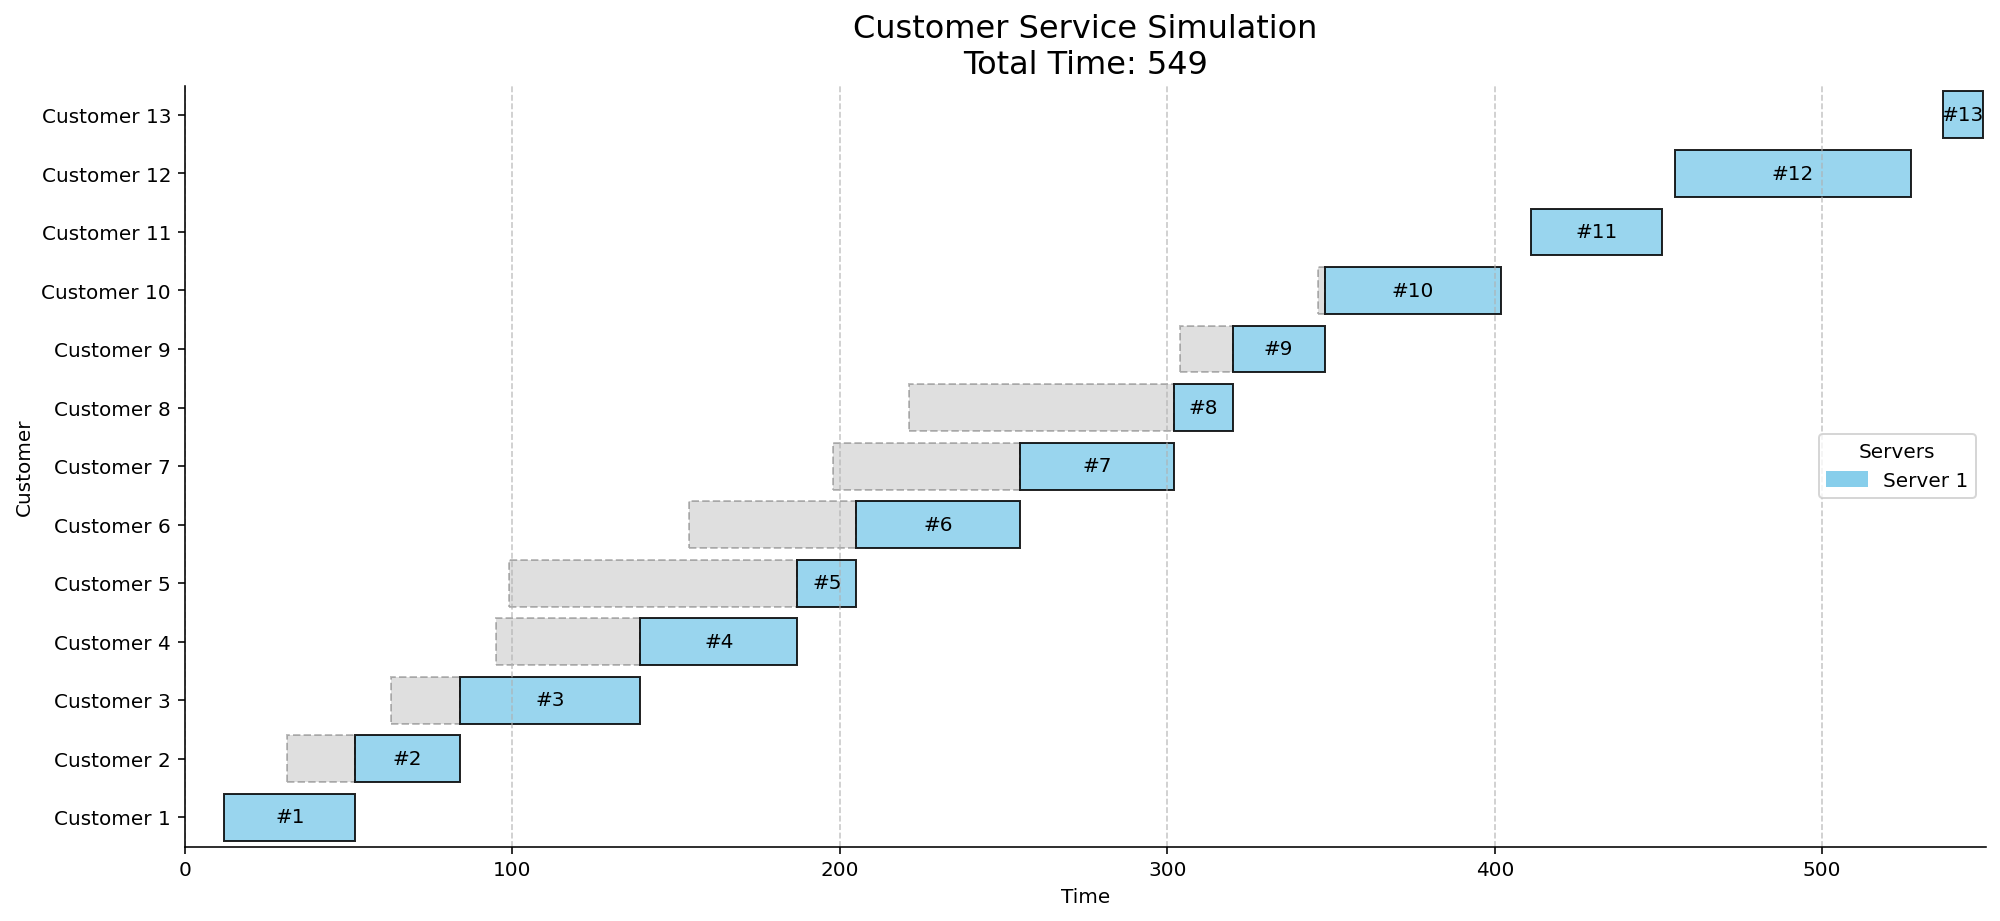

In [4]:
server_system = ServerSystem(num_servers=1)

for customer in customers:
    server_system.env.process(process_customer(server_system, customer, priority=customer.arrival_time, verbose=True))

server_system.env.run()

summarize_simulation(customers)
visualize_simulation(customers, server_system, "figs/single_server_simulation.svg")

Customer # | Arrival | In Queue | Service start | Server | Service Length | Departure
         1 |      12 |        0 |            12 |      1 |             40 |        52
         2 |      31 |        0 |            31 |      2 |             32 |        63
         3 |      63 |        0 |            63 |      1 |             55 |       118
         4 |      95 |        0 |            95 |      2 |             48 |       143
         5 |      99 |       19 |           118 |      1 |             18 |       136
         6 |     154 |        0 |           154 |      1 |             50 |       204
         7 |     198 |        0 |           198 |      2 |             47 |       245
         8 |     221 |        0 |           221 |      1 |             18 |       239
         9 |     304 |        0 |           304 |      1 |             28 |       332
        10 |     346 |        0 |           346 |      1 |             54 |       400
        11 |     411 |        0 |           411 |     

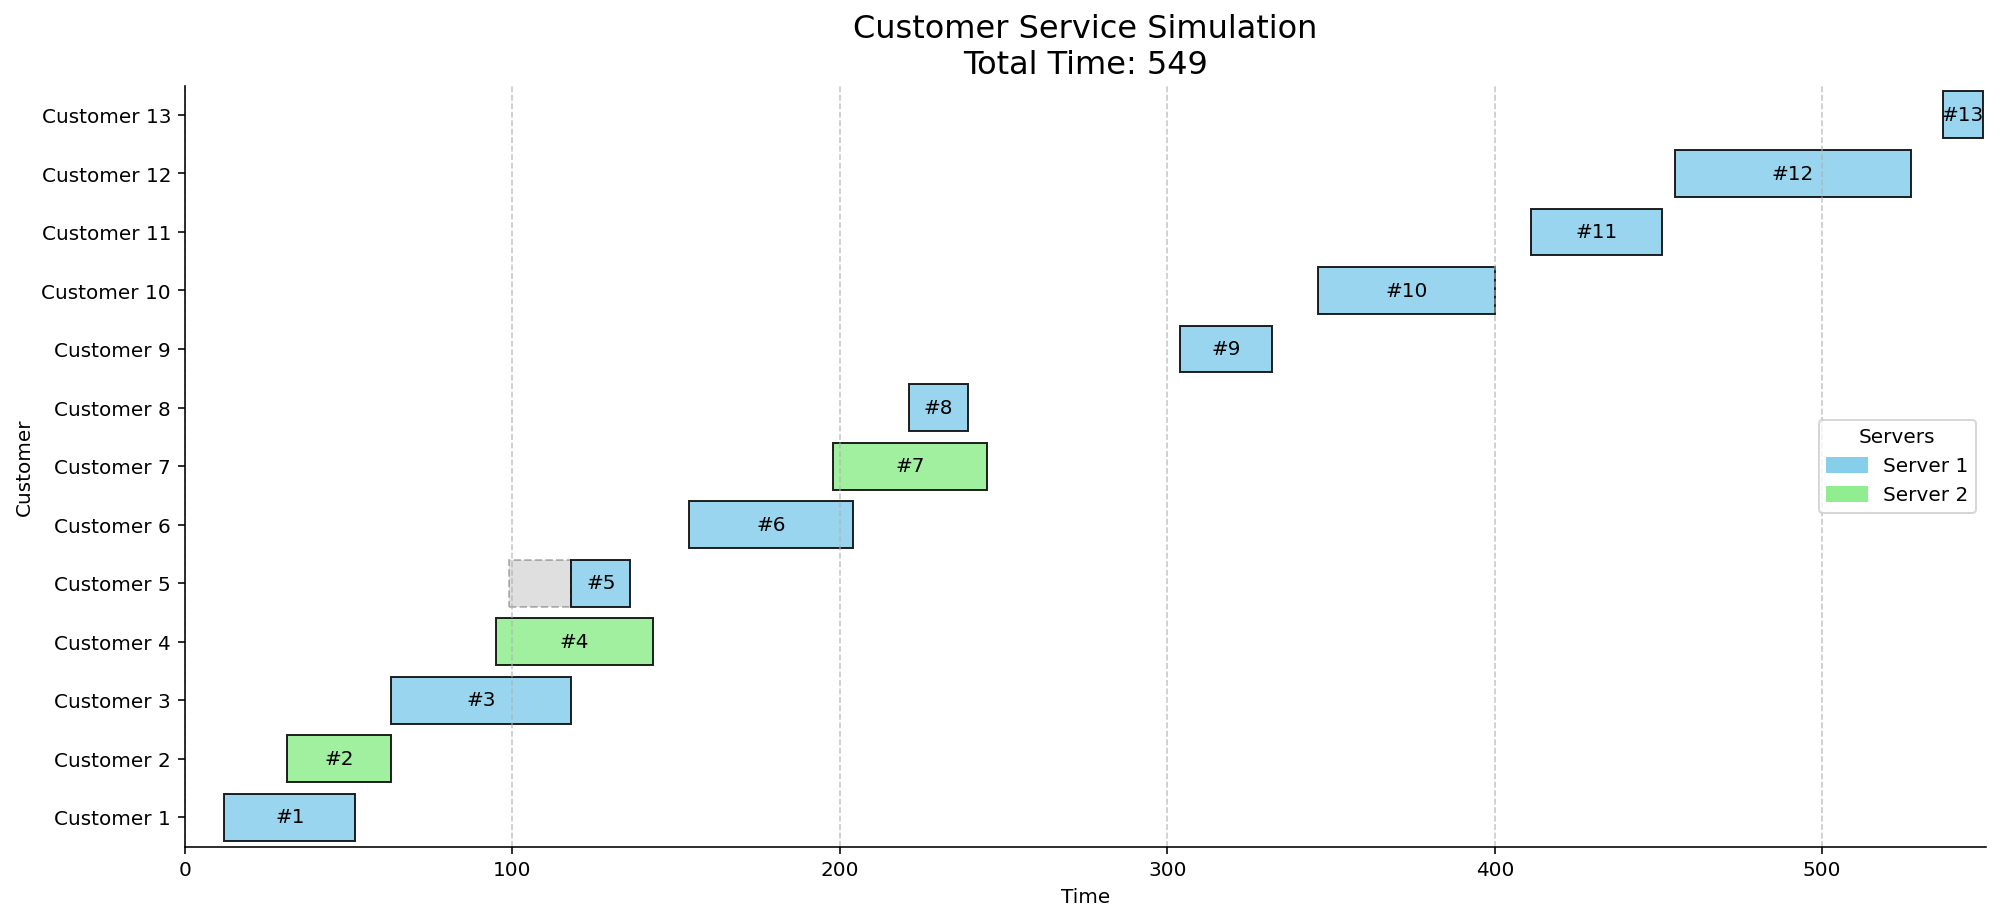

In [ ]:
server_system = ServerSystem(num_servers=2)

for customer in customers:
    server_system.env.process(process_customer(server_system, customer, priority=customer.arrival_time, verbose=True))

server_system.env.run()

summarize_simulation(customers)
visualize_simulation(customers, server_system, "figs/double_server_simulation.svg")

Customer # | Arrival | In Queue | Service start | Server | Service Length | Departure
         1 |      12 |        0 |            12 |      1 |             40 |        52
         2 |      31 |       21 |            52 |      1 |             32 |        84
         3 |      63 |       21 |            84 |      1 |             55 |       139
         4 |      95 |      177 |           272 |      1 |             48 |       320
         5 |      99 |       40 |           139 |      1 |             18 |       157
         6 |     154 |        3 |           157 |      1 |             50 |       207
         7 |     198 |        9 |           207 |      1 |             47 |       254
         8 |     221 |       33 |           254 |      1 |             18 |       272
         9 |     304 |       16 |           320 |      1 |             28 |       348
        10 |     346 |        2 |           348 |      1 |             54 |       402
        11 |     411 |        0 |           411 |     

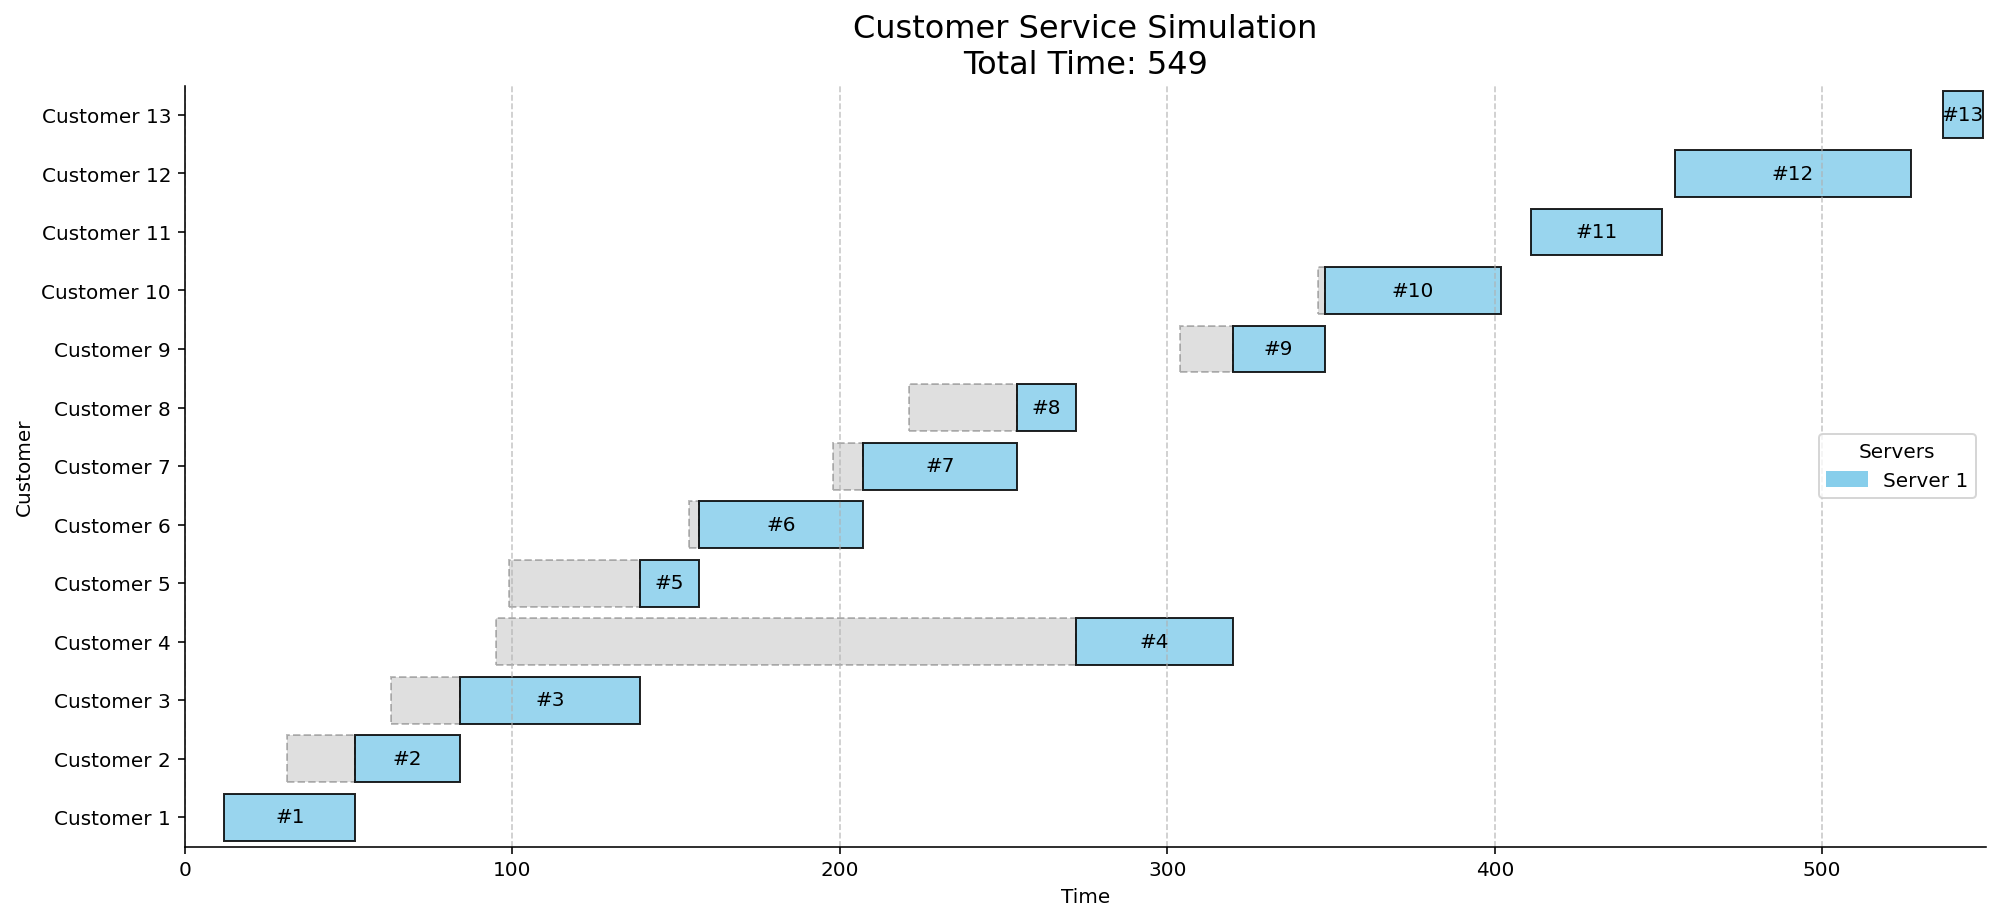

In [6]:
server_system = ServerSystem(num_servers=1)

for customer in customers:
    server_system.env.process(process_customer(server_system, customer, priority=-customer.arrival_time))

server_system.env.run()

summarize_simulation(customers)
visualize_simulation(customers, server_system, "figs/single_server_simulation_shortest_waiting.svg")

Customer # | Arrival | In Queue | Service start | Server | Service Length | Departure
         1 |      12 |        0 |            12 |      1 |             40 |        52
         2 |      31 |        0 |            31 |      2 |             32 |        63
         3 |      63 |        0 |            63 |      1 |             55 |       118
         4 |      95 |        0 |            95 |      2 |             48 |       143
         5 |      99 |       19 |           118 |      1 |             18 |       136
         6 |     154 |        0 |           154 |      1 |             50 |       204
         7 |     198 |        0 |           198 |      2 |             47 |       245
         8 |     221 |        0 |           221 |      1 |             18 |       239
         9 |     304 |        0 |           304 |      1 |             28 |       332
        10 |     346 |        0 |           346 |      1 |             54 |       400
        11 |     411 |        0 |           411 |     

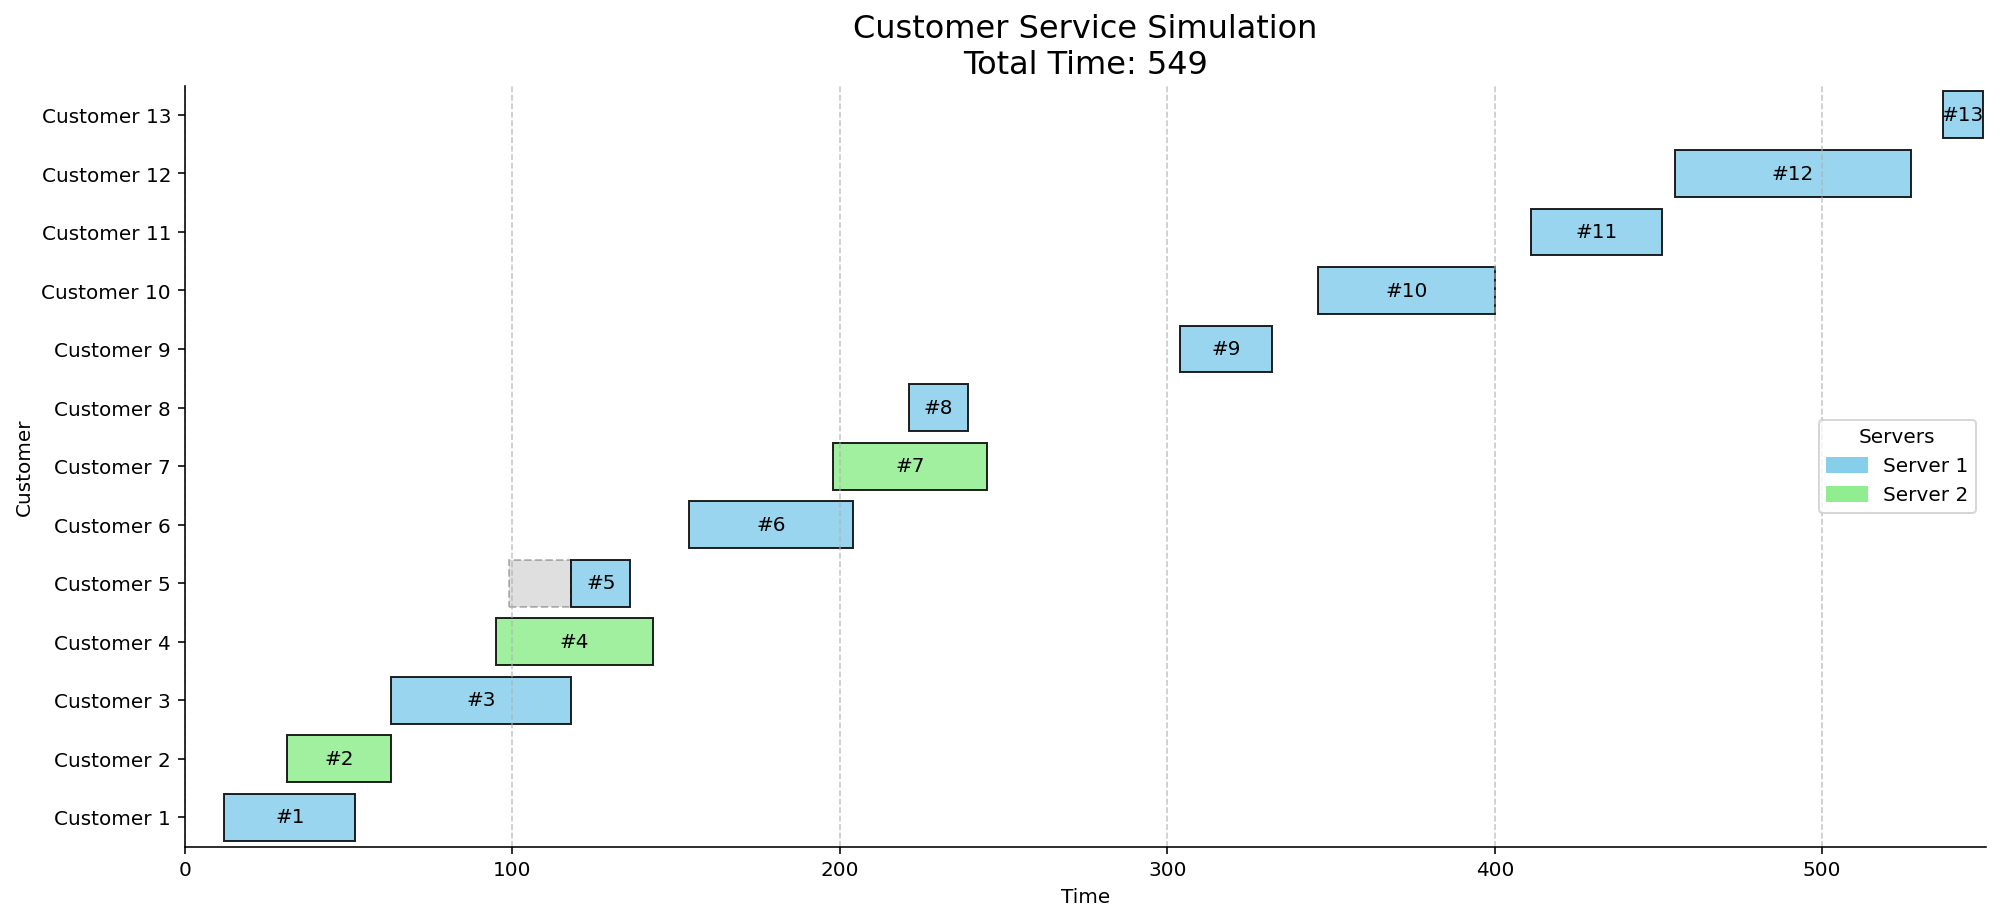

In [7]:
server_system = ServerSystem(num_servers=2)

for customer in customers:
    server_system.env.process(process_customer(server_system, customer, priority=-customer.arrival_time))

server_system.env.run()

summarize_simulation(customers)
visualize_simulation(customers, server_system, "figs/double_server_simulation_shortest_waiting.svg")

Customer # | Arrival | In Queue | Service start | Server | Service Length | Departure
         1 |      12 |        0 |            12 |      1 |             40 |        52
         2 |      31 |        0 |            31 |      2 |             32 |        63
         3 |      63 |        0 |            63 |      1 |             55 |       118
         4 |      95 |        0 |            95 |      2 |             48 |       143
         5 |      99 |        0 |            99 |      3 |             18 |       117
         6 |     154 |        0 |           154 |      1 |             50 |       204
         7 |     198 |        0 |           198 |      2 |             47 |       245
         8 |     221 |        0 |           221 |      1 |             18 |       239
         9 |     304 |        0 |           304 |      1 |             28 |       332
        10 |     346 |        0 |           346 |      1 |             54 |       400
        11 |     411 |        0 |           411 |     

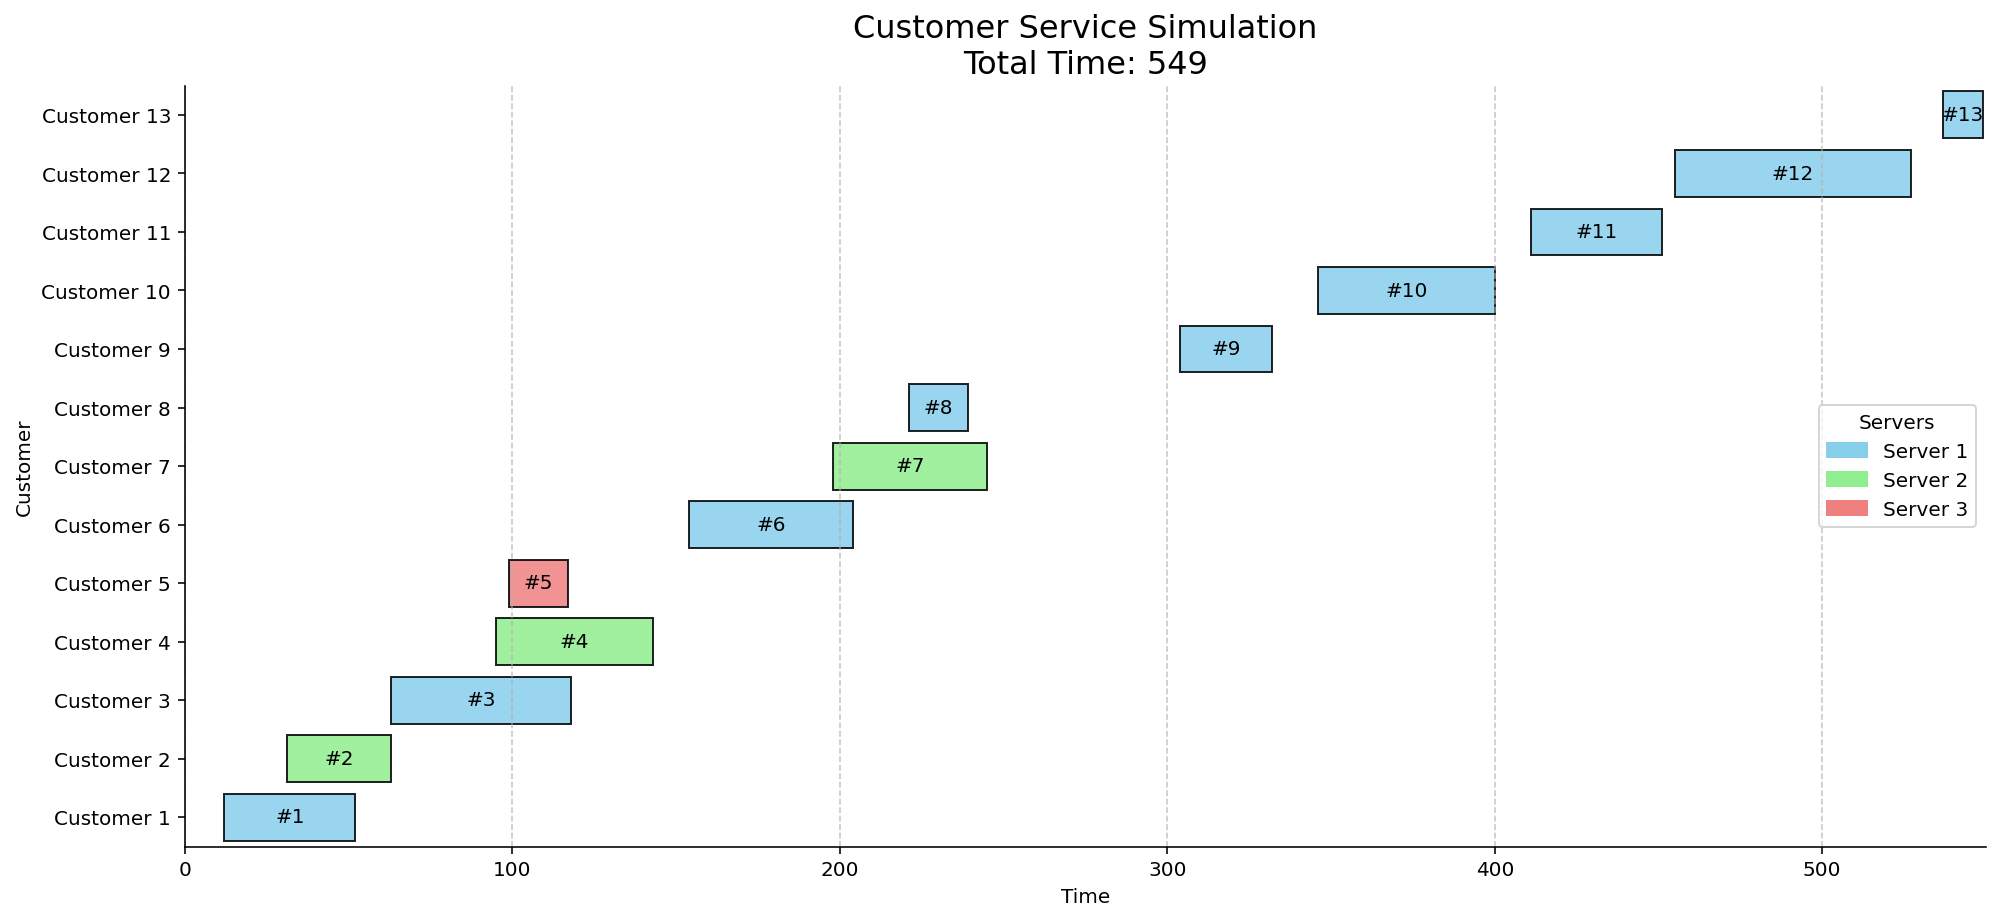

In [8]:
server_system = ServerSystem(num_servers=3)

for customer in customers:
    server_system.env.process(process_customer(server_system, customer, priority=customer.arrival_time))

server_system.env.run()

summarize_simulation(customers)
visualize_simulation(customers, server_system, "figs/triple_server_simulation.svg")